## PreProcessing Step
### the following issues need to be handled
1. some images are inverted (white is used for font and black for background unlike the majority)
2. light differs (you need to binarize and enhance the image quality)



In [1]:
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
classes = ['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']

In [3]:
x, y = load_data()
print(x.shape)
print(y.shape)

(1684,)
(1684,)


(61, 278, 3)
The ground-truth value of this image is:  Squar-kufic


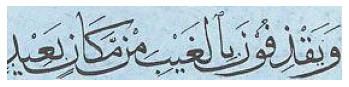

In [4]:
random_index = np.random.randint(0, 1683)

# Plot the image.
print(x[random_index].shape)
plt.imshow(x[random_index])
plt.axis("off")

print("The ground-truth value of this image is: ",
      classes[y[random_index]])